In [93]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import CubicSpline
import scipy
import h5py
import git

# other imports
import sys
sys.path.append('/oak/stanford/orgs/simes/rebjin/dqmc-dev/util')
import maxent
import util
import info
import os
import seaborn as sns
import pandas as pd 
# import re
import scienceplots
plt.style.use(['science','no-latex'])
plt.rcParams["figure.dpi"] = 150
plt.rcParams.update({'font.size': 13, 'axes.titlesize':18, 'axes.labelsize':16})

from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg')

class HiddenPrints:
    def __enter__(self):
        self._original_stdout = sys.stdout
        sys.stdout = open(os.devnull, 'w')

    def __exit__(self, exc_type, exc_val, exc_tb):
        sys.stdout.close()
        sys.stdout = self._original_stdout

/tmp/ipykernel_12291/3337389412.py:24: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('svg')


In [94]:
def get_sigma_xx(path, mdl, w, dw, bs=0):
    ### Specifically for Re[sigma_xx] (only pulls jxjx/jyjy correlators, uses symmetric bosonic kernel)
    # Added chiq0 = real(chiq0) for data with nflux != 0
    ### this func was made for symmetric w
    ###**** I have to multiply by 2 when using a range of w like [-w_max, w_max) and not [0, w_max), currently has this factor of 2
    
    ### Get model params
    # path is a folder with a bunch of bins in it (one folder labeled by U, beta, etc.)
    Ny, Nx, beta, L, tp = util.load_firstfile(
        path, "metadata/Nx", "metadata/Ny", "metadata/beta", "params/L", "metadata/t'"
    ) # tp is t', second neighbor hopping
    print(f"L = {L}", f"N (# w) = {len(w)}")
    
    ### Load in measurements
    n_sample, sign, jj = util.load(
        path, "meas_uneqlt/n_sample", "meas_uneqlt/sign", "meas_uneqlt/jj"
    ) 
    taus = np.linspace(0, beta, L + 1)
    # sign and n_sample are just the usual 1D arrays of total sum measurements for each bin
    
    # Only keep measurements from bins where n_sample is max value
    mask = n_sample == n_sample.max()   
    sign, jj = sign[mask], jj[mask]
    nbin = mask.sum()
    
    ### Reshape jj
    # jj needs to be shaped into a 2x2 matrix (or 4x4, for nonzero t') discretized in tau + containing info from bond to bond (indexed by lattice site)
    # 1xt index of jj still bin (usually len 60)
    jj.shape = -1, L, 2, 2, Ny, Nx
    jjq0 = jj.sum((-1, -2))   # sum over all the bonds (since q=0)

    ### Get average longitudinal jj
    jxjxq0 = -( # add up all the x current contributions (for each bin, so still bin + tau separated)
        jjq0[..., 0, 0]
        # + tp * jjq0[..., 0, 2]
        # - tp * jjq0[..., 0, 3]
        # + tp * jjq0[..., 2, 0]
        # + tp * tp * jjq0[..., 2, 2]
        # - tp * jjq0[..., 3, 0]
        # + tp * tp * jjq0[..., 3, 3]
    )
    jyjyq0 = -( # same for y current
        jjq0[..., 1, 1]
        # + tp * jjq0[..., 1, 2]
        # + tp * jjq0[..., 1, 3]
        # + tp * jjq0[..., 2, 1]
        # + tp * tp * jjq0[..., 2, 2]
        # + tp * jjq0[..., 3, 1]
        # + tp * tp * jjq0[..., 3, 3]
    )
    # average over xx and yy to get avg longitudinal current current data (improved statistics)
    chiq0 = 0.5 * (jxjxq0 + jyjyq0)   
    # correlation func looks like a symmetric dip in tau, symmetrize the data (improved statistics again)
    chiq0 = 0.5 * (chiq0 + chiq0[:, -np.arange(L) % L]) # shape of chiq0 is (60, 10): (bin, imaginary time)
    chiq0 = np.real(chiq0) # added for nflux != 0 data, chiq0 should be purely real
    
    ### MaxEnt
    chiq0 /= n_sample.max()   
    sign /= n_sample.max()   # get avg measurements for each bin
    # sign = np.real(sign)# added for nflux != 0 data
    # print(f"nbin={nbin}\t<sign>={sign.mean()}")

    # Choose kernel and model to use (symmetric bosonic)
    krnl = maxent.kernel_b(beta, taus[0 : L // 2 + 1], w, sym=True)    ### oohhhh this truncated Tau thing is specifically bc symmetry, have to change
    if mdl is None:
        # default flat model
        mdl = maxent.model_flat(dw)
        useBT = True  # useBT is just a choice of algorithm to pick alpha
    else:
        useBT = False
    
    # bs = bootstrapping
    if bs > 0:
        As = np.zeros((bs, len(w)))
        mdls = np.zeros((bs, len(w)))
        if mdl.shape == w.shape:
            mdl = np.broadcast_to(mdl, (bs, len(w)))
        for i in range(bs):
            resample = np.random.randint(0, nbin, nbin)   # 1D array of random ints nbin long
            f = chiq0[resample].mean(0)   # take a random resample with replacement of bins of imaginary time correlator
            chiq0w0 = CubicSpline(taus, np.append(f, f[0])).integrate(0, beta)  # just the definition
            g = 2 * chiq0[resample, : L // 2 + 1] / chiq0w0
            A = maxent.calc_A(
                g, krnl, mdl[i] + np.nextafter(0, 1), plot=False, useBT=useBT
            )
            mdls[i] = A / A.sum()
            As[i] = np.real(A / dw * (chiq0w0 / sign[resample].mean())) * np.pi / 2*2
        return As, mdls   # As is now list of sigmas/measurements obtained for each resampling, get error from st. dev. of resampled measurements
    else:
        # no bootstrapping
        f = chiq0.mean(0)   # mean among bins, separated by tau, shape (10)
        chiq0w0 = CubicSpline(taus, np.append(f, f[0])).integrate(0, beta)  # G^O(i w_n = 0), used in def of G and A
        g = 2 * chiq0[:, : L // 2 + 1] / chiq0w0
        # A = maxent.calc_A(g, krnl, mdl, plot=False, useBT=useBT)
        A = calc_A(g, krnl, mdl)
        sigmas_xx = np.real(A / dw * (chiq0w0 / sign.mean())) * np.pi/2*2 #### final factor of 2 for range of w centered at (not starting at) 0
        return sigmas_xx, A / A.sum()    # A multipled by extra constants to get actual sigma, just detail of maxent implementation

In [4]:
def get_sigma_sum(path, mdl, w, dw, bs=0, plot_chi_xy=False):
    ### Get sigma_xy precursor Re[sigma_xx] + Im[sigma_xy]
    # (pulls jxjx/jyjy + jxjy/jyjx correlators, uses non-symmetric bosonic kernel)
    # (also removed instructional comments, they're on sigma_xx function)
    
    # Get model params
    Ny, Nx, beta, L, tp = util.load_firstfile(
        path, "metadata/Nx", "metadata/Ny", "metadata/beta", "params/L", "metadata/t'"
    )
    
    # Load in measurements
    n_sample, sign, jj = util.load(
        path, "meas_uneqlt/n_sample", "meas_uneqlt/sign", "meas_uneqlt/jj"
    ) 
    taus = np.linspace(0, beta, L + 1)
    
    # Only keep measurements from bins where n_sample is max value
    mask = n_sample == n_sample.max()   
    sign, jj = sign[mask], jj[mask]
    nbin = mask.sum()
    
    # Reshape jj into a 2x2 matrix (or 4x4, for nonzero t') discretized in tau + containing info from bond to bond (indexed by lattice site)
    jj.shape = -1, L, 2, 2, Ny, Nx
    jjq0 = jj.sum((-1, -2))   # sum over all the bonds (since q=0)

    # Get average longitudinal jj
    jxjxq0 = -jjq0[..., 0, 0]
    jyjyq0 = -jjq0[..., 1, 1]
    chi_xx = 0.5 * (jxjxq0 + jyjyq0) # average over xx and yy to get avg longitudinal current current data (improved statistics)
    chi_xx = 0.5 * (chi_xx + chi_xx[:, -np.arange(L) % L]) # symmetrize the data
    chi_xx = np.real(chi_xx) # added for nflux != 0 data, chiq0 should be purely real
    
    # Get average jxjy
    # current configuration: xy current correlator slopes up
    jxjyq0 = jjq0[..., 1, 0]   # ***is this supposed to be minus or plus? idk but clearly one of them should be minus
    jyjxq0 = -jjq0[..., 0, 1]
    chi_xy = 0.5*(jxjyq0+jyjxq0)   # ****also do you still do this
    chi_xy = np.concatenate((np.expand_dims(chi_xy[:, 0], axis=1), 0.5*(chi_xy[:, 1:] - chi_xy[:, :0:-1])), axis=1) ### antisymmetrizing step, idk if I'm supposed to do this lol
    chi_xy = 1j*np.imag(chi_xy) # added for nflux != 0 data, should be purely imaginary

    # plot correlators
    if plot_chi_xy:
        fig, ax = plt.subplots(figsize=(6, 2), ncols=3, layout='constrained')
        titles = [r"$ \langle j_x j_y \rangle $", r"$ \langle j_y j_x \rangle $", r"$\chi_{xy}$ (tot)"]
        ax[0].plot(np.mean(np.imag(jxjyq0), axis=0))
        ax[1].plot(np.mean(np.imag(jyjxq0), axis=0))
        ax[2].plot(np.mean(np.imag(chi_xy), axis=0))
        for i in range(3): 
            ax[i].set_title(titles[i])
            ax[i].set_xlabel(r'$\tau$')
        plt.suptitle(rf"U = {U}, $\beta$ = {beta}")
    
    ### MaxEnt
    chi_xy /= n_sample.max()
    chi_xx /= n_sample.max()   
    sign /= n_sample.max()   # get avg measurements for each bin
    # sign = np.real(sign)# added for nflux != 0 data
    # print(f"nbin={nbin}\t<sign>={sign.mean()}")
    
    # Choose kernel and model to use (bosonic non-symmetric)
    krnl = maxent.kernel_b(beta, taus[:-1], w, sym=False)
    if mdl is None:
        # default flat model
        mdl = maxent.model_flat(dw)
        useBT = True  # useBT is just a choice of algorithm to pick alpha, supposed to be True here
    else:
        useBT = False
    
    # bs = bootstrapping
    if bs > 0:
        As = np.zeros((bs, len(w)))
        mdls = np.zeros((bs, len(w)))
        if mdl.shape == w.shape:
            mdl = np.broadcast_to(mdl, (bs, len(w)))
        for i in range(bs):
            resample = np.random.randint(0, nbin, nbin)   # 1D array of random ints nbin long
            f = np.append(chi_xx[resample].mean(0), chi_xx[resample].mean(0)[0]) - np.real(1j*np.append(chi_xy[resample].mean(0), -chi_xy[resample].mean(0)[0]))
            chiq0w0 = CubicSpline(taus, f).integrate(0, beta)  # G^O(i w_n = 0), used in def of G and A
            g = (chi_xx[resample] - np.real(1j*chi_xy[resample])) / chiq0w0   # ***changed this
            A = maxent.calc_A(
                g, krnl, mdl[i] + np.nextafter(0, 1), plot=False, useBT=useBT
            )
            mdls[i] = A / A.sum()
            As[i] = np.real(A / dw * (chiq0w0 / sign[resample].mean())) * np.pi
        return As, mdls   # As is now list of sigmas/measurements obtained for each resampling, get error from st. dev. of resampled measurements
    else:
        # no bootstrapping
        f = np.append(chi_xx.mean(0), chi_xx.mean(0)[0]) - np.real(1j*np.append(chi_xy.mean(0), -chi_xy.mean(0)[0]))
        # clunky expression bc f no longer symmetric, but have to include tau = beta point
        chiq0w0 = CubicSpline(taus, f).integrate(0, beta)  # G^O(i w_n = 0), used in def of G and A
        g = (chi_xx - np.real(1j*chi_xy)) / chiq0w0   # ***changed this
        A = maxent.calc_A(g, krnl, mdl, plot=False, useBT=useBT)
        sigmas_sum = np.real(A / dw * (chiq0w0 / sign.mean())) * np.pi
        return sigmas_sum, 0



In [6]:
def find_nearest(array, value, get_idx = False):
    diff_arr = array - value
    if array.ndim == 1:
        diff_mag_arr = np.abs(diff_arr)
    else:
        diff_mag_arr = np.linalg.norm(diff_arr, axis=-1)
    idx = (diff_mag_arr).argmin()
    diff = value - array[idx]
    if get_idx:
        return idx
    else:
        return array[idx]

def plot_sigmas(ws, sigmas_w, U, beta, yerr=None, ylabel='', label=''):
    fig, ax = plt.subplots(figsize = [6.4, 4.8])
    # plt.errorbar(ws, re_sigmas_xx, yerr=re_sigmas_xx_err)
    if np.any(yerr):
        ax.errorbar(ws, sigmas_w, yerr=yerr, fmt='s-', lw=0.7, ms=0, label=label, capsize=0, ecolor='orange', elinewidth=0.5)
    else:
        ax.scatter(ws, sigmas_w, s=1, label=label)
    plt.xlabel(r'$\omega$')
    plt.ylabel(ylabel)
    plt.title(rf'{ylabel}: U = {U}, $\beta$ = {beta}')
    if label:
        plt.legend()

def plot_sigmas2(ws, bs_sigmas_w, U, beta, ylabel=''):
    '''This version just plots all the bootstrapped sigmas on top of each other'''
    num_bs = len(bs_sigmas_w)
    fig, ax = plt.subplots(figsize = [6.4, 4.8])
    for i in range(num_bs):
        ax.plot(ws, bs_sigmas_w[i], lw=1, color='#0C5DA5', alpha=0.9)
    plt.xlabel(r'$\omega$')
    plt.ylabel(ylabel)
    plt.title(rf'{ylabel}: U = {U}, $\beta$ = {beta}')

#### $\sigma_{xx}$ Test

In [40]:
# rq relook at what the h5 files look like again, what measurements there are
parent_dir = '/oak/stanford/orgs/simes/rebjin/nflux0_n0.9/'
path = parent_dir + 'beta0.125_U10_mu-2.317/batch_0.h5'   # choose a random test file

with h5py.File(path, "r") as f:
    print(list(f.keys()))
    print("Equal time measurements: ", list(f['meas_eqlt'].keys()))
    print("Unequal time measurements: ", list(f['meas_uneqlt'].keys()))

['meas_eqlt', 'meas_uneqlt', 'metadata', 'params', 'state']
Equal time measurements:  ['density', 'double_occ', 'g00', 'n_sample', 'nn', 'pair_sw', 'sign', 'xx', 'zz']
Unequal time measurements:  ['gt0', 'jj', 'jsjs', 'kk', 'ksks', 'n_sample', 'nn', 'pair_bb', 'pair_sw', 'sign', 'xx', 'zz']


In [140]:
def get_sigma_w(path, mdl, w, dw, bs=0):    
    ### get model params
    # path is a folder with a bunch of bins in it (a set of runs for one choice of U, beta, etc.)
    # tp is t', second neighbor hopping
    Ny, Nx, beta, L, tp = util.load_firstfile(
        path, "metadata/Nx", "metadata/Ny", "metadata/beta", "params/L", "metadata/t'"
    )
    
    ### load in measurements
    n_sample, sign, jj = util.load(
        path, "meas_uneqlt/n_sample", "meas_uneqlt/sign", "meas_uneqlt/jj"
    )
    taus = np.linspace(0, beta, L + 1)
    # sign and n_sample are just the usual 1D arrays of total sum measurements for each bin
    # 1st index of jj is still bin, but each measurement is initally outputed as a 1D array itself of a bunch of real #s
    
    # only keep measurements from bins where n_sample is max value
    mask = n_sample == n_sample.max()   
    sign, jj = sign[mask], jj[mask]
    nbin = mask.sum()
    
    ### reshape jj
    # jj is a 2x2 matrix (or 4x4, for nonzero t') discretized in tau + containing info from bond to bond (indexed by lattice site)
    # 1xt index of jj still bin
    jj.shape = -1, L, 2, 2, Ny, Nx
    jjq0 = jj.sum((-1, -2))   # sum over all the bonds (don't care about bond to bond info since q=0)

    # add up all the x current contributions (for each bin, so still bin + tau separated)
    jxjxq0 = -(
        jjq0[..., 0, 0]
        # + tp * jjq0[..., 0, 2]
        # - tp * jjq0[..., 0, 3]
        # + tp * jjq0[..., 2, 0]
        # + tp * tp * jjq0[..., 2, 2]
        # - tp * jjq0[..., 3, 0]
        # + tp * tp * jjq0[..., 3, 3]
    )
    # same for y current
    jyjyq0 = -(
        jjq0[..., 1, 1]
        # + tp * jjq0[..., 1, 2]
        # + tp * jjq0[..., 1, 3]
        # + tp * jjq0[..., 2, 1]
        # + tp * tp * jjq0[..., 2, 2]
        # + tp * jjq0[..., 3, 1]
        # + tp * tp * jjq0[..., 3, 3]
    )
    # average over xx and yy to get avg longitudinal current current data (improved statistics)
    chiq0 = 0.5 * (jxjxq0 + jyjyq0)   
    # correlation func looks like a symmetric dip in tau, symmetrizes the data (improved statistics again)
    chiq0 = 0.5 * (chiq0 + chiq0[:, -np.arange(L) % L])
    
    ### maxent
    chiq0 /= n_sample.max()   # shape of chiq0 is (60, 10): (bin, imaginary time)
    sign /= n_sample.max()   # get avg measurements for each bin
    # print(f"nbin={nbin}\t<sign>={sign.mean()}")

    # get the bosonic kernel
    krnl = maxent.kernel_b(beta, taus[0 : L // 2 + 1], w, sym=True)
    if mdl is None:
        # default flat model
        mdl = maxent.model_flat(dw)
        useBT = True  # useBT is just a choice of algorithm to pick alpha
    else:
        useBT = False
    
    # bs = bootstrapping
    if bs > 0:
        As = np.zeros((bs, len(w)))
        mdls = np.zeros((bs, len(w)))
        if mdl.shape == w.shape:
            mdl = np.broadcast_to(mdl, (bs, len(w)))
        for i in range(bs):
            resample = np.random.randint(0, nbin, nbin)   # 1D array of random ints nbin long
            f = chiq0[resample].mean(0)   # take a random resample with replacement of bins of imaginary time correlator
            chiq0w0 = CubicSpline(taus, np.append(f, f[0])).integrate(0, beta)  # just the definition
            g = 2 * chiq0[resample, : L // 2 + 1] / chiq0w0
            #             print(i)
            #             global gg, kk, mm
            #             gg, kk, mm = g, krnl, mdl
            A = maxent.calc_A(
                g, krnl, mdl[i] + np.nextafter(0, 1), plot=False, useBT=useBT
            )
            mdls[i] = A / A.sum()
            As[i] = A / dw * (chiq0w0 / sign[resample].mean()) * np.pi / 2
        return As, mdls   # As is now list of sigmas/measurements obtained for each resampling, get error from st. dev. of resampled measurements
    else:
        # no bootstrapping
        f = chiq0.mean(0)   # mean among bins, separated by tau, shape (10)
        chiq0w0 = CubicSpline(taus, np.append(f, f[0])).integrate(0, beta)  # G^O(i w_n = 0), used in def of G and A
        g = 2 * chiq0[:, : L // 2 + 1] / chiq0w0
    
        A = maxent.calc_A(g, krnl, mdl, plot=False, useBT=useBT)
        return A / dw * (chiq0w0 / sign.mean()) * np.pi / 2, A / A.sum()    # A multipled by extra constants, just detail of maxent implementation

In [38]:
### Make a plot for sigma_xx looping through all the temperatures
### include error for each point with bootstrapping

# Choose dir and U to plot from + sigma params
parent_dir = '/oak/stanford/orgs/simes/rebjin/nflux0_n0.9/'
U = 6
nw_sym = 80
w_sym, dw_sym = maxent.gen_grid(nw_sym, 0, 2.1, lambda x: 0.4 * np.sinh(2.5 * x))
num_bs = 50

# For choice of U, get sigma(w) for all betas
row_list = []
for subdir, dirs, files in os.walk(parent_dir):
    if f'U{U}' in subdir:
        # Get model params
        path = subdir+'/'
        Ny, Nx, beta, L, tp = util.load_firstfile(
            path, "metadata/Nx", "metadata/Ny", "metadata/beta", "params/L", "metadata/t'"
        )
        T = np.round(1/beta, 2)
        # print(f"Params:\nNy = {Ny}, Nx = {Nx}, beta = {beta}, L = {L}, tp = {tp}")
        print(f"Beta = {beta}")

        # Get sigmas
        sigmas, _ = get_sigma_w(path, None, w_sym, dw_sym, bs = 0)
        # Get errors with bootstrapping
        with HiddenPrints():
            sigmas_bs, _ = get_sigma_w(path, None, w_sym, dw_sym, bs = num_bs)
        sigmas_err = np.std(sigmas_bs, axis=0)
        
        # Add dict to row_list
        dict = {
            'beta': beta,
            'U': U, 
            'T': T,
            'sigmas': sigmas, 
            'sigmas_err': sigmas_err
        }
        row_list.append(dict)
    
# Make DataFrame from list of dicts
df = pd.DataFrame(row_list)
df = df.sort_values(by=['beta'], ascending = False)
df = df.reset_index(drop=True)
print(df)

Beta = 0.25
alpha=15848.932	chi2/dof=0.639	A.sum()=0.999998
Beta = 1.0
alpha=12589.254	chi2/dof=2.590	A.sum()=0.999546
Beta = 1.25
alpha=1778.279	chi2/dof=0.383	A.sum()=0.999942
Beta = 0.7000000000000001
alpha=89.125	chi2/dof=0.027	A.sum()=0.999905
Beta = 0.125
alpha=28183.829	chi2/dof=1.865	A.sum()=0.999994
Beta = 1.5
alpha=141.254	chi2/dof=0.117	A.sum()=0.999526
Beta = 2.0
alpha=501.187	chi2/dof=0.582	A.sum()=0.999527
Beta = 3.0
alpha=794.328	chi2/dof=0.447	A.sum()=0.999518
Beta = 0.5
alpha=63.096	chi2/dof=0.034	A.sum()=0.999980


KeyboardInterrupt: 

Text(0.5, 1.0, 'U = 6')

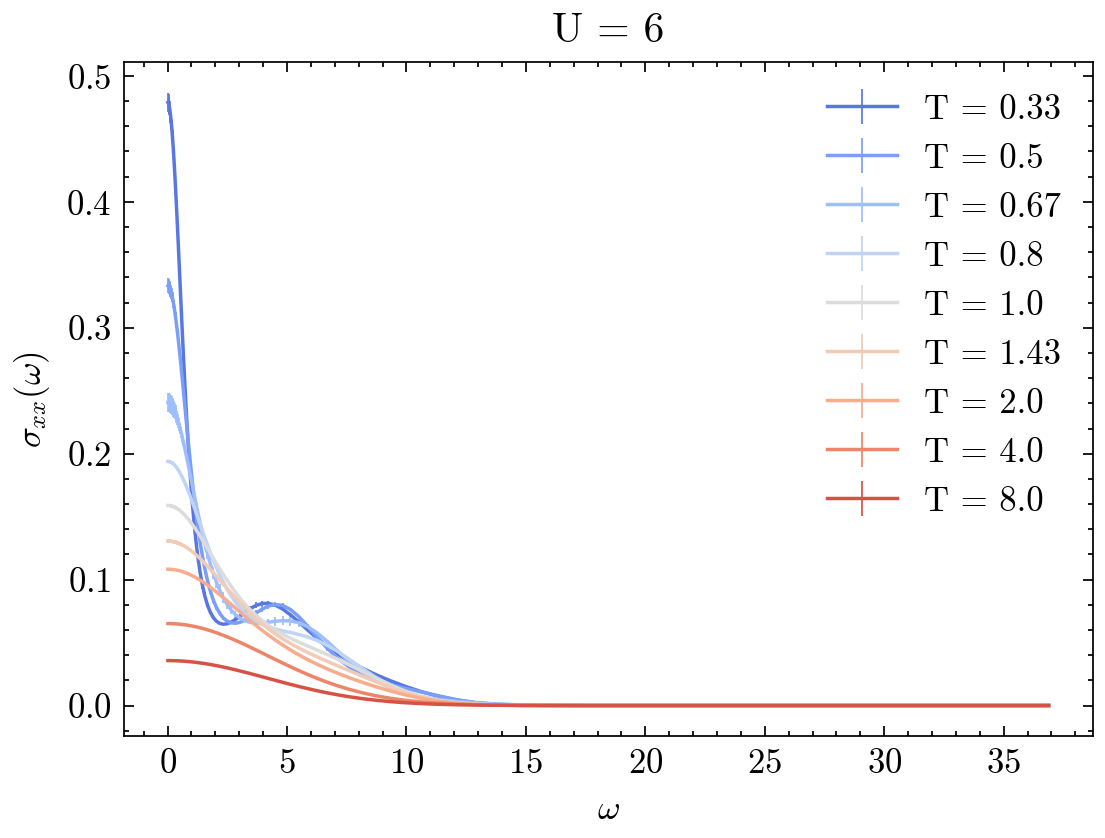

In [19]:
# Plot results
plt.rcParams["figure.dpi"] = 250
colors = sns.color_palette('coolwarm', df.shape[0])

plt.figure(figsize = (5, 3.5))
for ind in df.index:
    sigmas_err = df['sigmas_err'][ind]
    sigmas = df['sigmas'][ind]
    T = df['T'][ind]
    plt.errorbar(w_sym, sigmas, yerr = sigmas_err, label = f'T = {T}', color = colors[ind], elinewidth=0.5)

plt.legend()
plt.xlabel(r'$\omega$')
plt.ylabel(r'$\sigma_{xx}(\omega)$')
plt.title(f'U = {U}')

# print(list(df[df['T']==8.00]['sigmas_err']))
# print(list(df[df['T']==0.67]['sigmas_err']))

[7.47751684e-03 5.88461516e-03 7.63051996e-03 1.41538781e-03
 1.42320296e-03 1.50616235e-03 8.90009520e-04 1.14202736e-04
 6.33378065e-05]
[0.03259832 0.05297338 0.13165236 0.03763392 0.05636096 0.08830198
 0.07595758 0.02697207 0.04976391]


<Figure size 875x656.25 with 0 Axes>

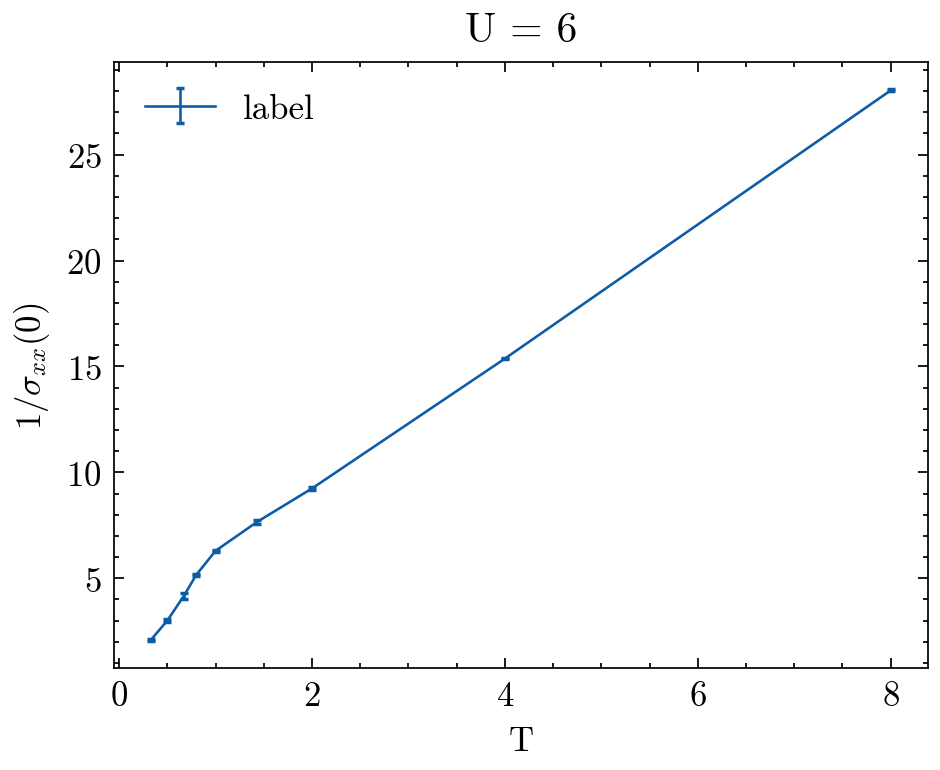

In [60]:
### Plot rho vs. T
sigmas_0 = np.array([sigmas[0] for sigmas in df['sigmas']])
sigmas_0_err = np.array([sigmas_err[0] for sigmas_err in df['sigmas_err']])
rhos_0 = 1/sigmas_0
rhos_0_err = (1/sigmas_0**2)*sigmas_0_err    # followed error formula for 1/x, idk
print(sigmas_0_err)
print(rhos_0_err)

fig, ax = plt.subplots(figsize = 1.2*plt.gcf().get_size_inches())
ax.errorbar(df['T'], rhos_0, yerr=rhos_0_err, fmt='s-', lw=0.75, ms=0, label='label', capsize=1.2)

ax.set_xlabel('T')
ax.set_ylabel('$1/\sigma_{xx} (0)$')
ax.set_title(f'U = {U}')
ax.legend()
# plt.savefig("newest_fig.png", dpi=200)

/oak/stanford/orgs/simes/rebjin/nflux0_n0.9/beta0.125_U6_mu-1.992/
alpha=28183.829	chi2/dof=1.865	A.sum()=0.999994
(100,)
[5.23493105e-05 5.23427218e-05 5.23294728e-05 5.23094198e-05
 5.22823453e-05 5.22479557e-05 5.22058786e-05 5.21556588e-05
 5.20967535e-05 5.20285272e-05 5.19502451e-05 5.18610657e-05
 5.17600328e-05 5.16460659e-05 5.15179497e-05 5.13743230e-05
 5.12136653e-05 5.10342836e-05 5.08342964e-05 5.06116178e-05
 5.03639394e-05 5.00887113e-05 4.97831219e-05 4.94440764e-05
 4.90681746e-05 4.86516880e-05 4.81905361e-05 4.76802635e-05
 4.71160166e-05 4.64925232e-05 4.58040730e-05 4.50445030e-05
 4.42071876e-05 4.32850359e-05 4.22704993e-05 4.11555910e-05
 3.99319224e-05 3.85907594e-05 3.71231050e-05 3.55198126e-05
 3.37717383e-05 3.18699386e-05 2.98059240e-05 2.75719769e-05
 2.51615455e-05 2.25697281e-05 1.97938635e-05 1.68342630e-05
 1.36951623e-05 1.03861892e-05 6.92587523e-06 3.36222782e-06
 9.48659922e-07 4.35677839e-06 8.16053001e-06 1.19658612e-05
 1.56903289e-05 1.925433

Text(0.5, 1.0, 'U = 6, $\\beta$ = 0.125')

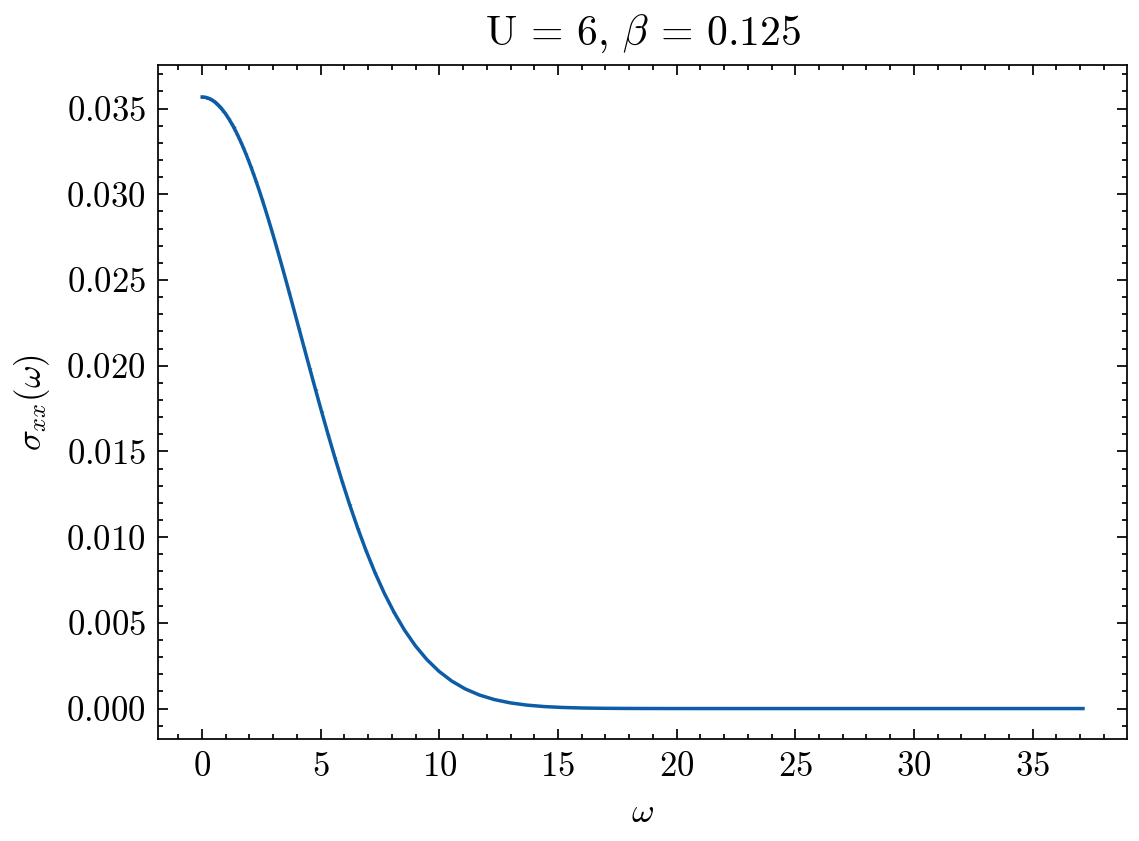

In [42]:
### Test sigma(w) plot for one U, beta
# include error bars with bootstrapping

parent_dir = '/oak/stanford/orgs/simes/rebjin/nflux0_n0.9/'
U = 6
beta = 0.125
# find filepath with specified U, beta
for subdir, dirs, files in os.walk(parent_dir):
    if f'U{U}' in subdir and f'beta{beta}' in subdir:
        path = subdir+'/'
print(path)

# Get sigmas
nw_sym = 100
w_sym, dw_sym = maxent.gen_grid(nw_sym, 0, 2.1, lambda x: 0.4 * np.sinh(2.5 * x))
sigmas, _ = get_sigma_w(path, None, w_sym, dw_sym)
print(sigmas.shape)
# Get error with bootstrapping
num_bs = 20
with HiddenPrints():
    bs_sigmas, _ = get_sigma_w(path, None, w_sym, dw_sym, bs=num_bs)   # first index bin, second index w
sigmas_err = np.std(bs_sigmas, axis=0)
print(sigmas_err)

plt.figure(figsize = (5, 3.5))
plt.errorbar(w_sym, sigmas, yerr=sigmas_err)
# plt.scatter(w_sym, sigmas, s = 1)
# plt.scatter(w_sym, sigmas[1], s = 1)
plt.xlabel(r'$\omega$')
plt.ylabel(r'$\sigma_{xx}(\omega)$')
plt.title(rf'U = {U}, $\beta$ = {beta}')

#### $\sigma_{xy}$ Test

In [95]:
### Standardize filepaths for U
U = 6
parent_dir = '/oak/stanford/orgs/simes/rebjin/nflux1_n0.9/'

row_list = []
for subdir, dirs, files in os.walk(parent_dir):
    if f'U{U}' in subdir and '/.ipynb_checkpoints' not in subdir:
        # Get path
        path = subdir+'/'
        
        # Get params
        Ny, Nx, beta, L, tp = util.load_firstfile(
            path, "metadata/Nx", "metadata/Ny", "metadata/beta", "params/L", "metadata/t'"
        )

        # Add to dict for df
        dict = {
            'path': path,
            'U': U,
            'beta': np.round(beta, 6), 
            'Ny': Ny,
            'Nx': Nx,
            'L': L,
            'tp': tp
        }
        row_list.append(dict)
        
params_df = pd.DataFrame(row_list)
params_df = params_df.sort_values(by=['beta'], ascending = False)
params_df = params_df.reset_index(drop=True)
pd.set_option('display.width', 2000)
print(params_df)

### Look through repeats (ok this was just a mistake of copying lol no more repeats)
# check_repeats = False
# if check_repeats:
#     print(params_df[params_df.duplicated(subset='beta', keep=False)])
#     for index, row in params_df[params_df.duplicated(subset='beta', keep=False)].iterrows():
#         path, beta, L = row['path'], row['beta'], row['L']
#         print(path)
#         n_sample, sign, jj = util.load(
#             path, "meas_uneqlt/n_sample", "meas_uneqlt/sign", "meas_uneqlt/jj"
#         )          
#         taus = np.linspace(0, beta, L + 1)

#         # Only keep measurements from bins where n_sample is max value
#         mask = n_sample == n_sample.max()   
#         sign, jj = sign[mask], jj[mask]
#         nbin = mask.sum()
        
#         # Check jxjy (0 for bad data I believe)
#         jj.shape = -1, L, 2, 2, Ny, Nx
#         jjq0 = jj.sum((-1, -2))   # sum over all the bonds (since q=0)
        
#         jxjyq0 = jjq0[..., 1, 0]
#         jyjxq0 = -jjq0[..., 0, 1]
#         chi_xy = 0.5*(jxjyq0+jyjxq0)   # ****also do you still do this
#         chi_xy = 1j*np.imag(chi_xy) # added for nflux != 0 data, should be purely imaginary
    
#         # plot correlators
#         fig, ax = plt.subplots(figsize=(6, 2), ncols=3, layout='constrained')
#         titles = [r"$ \langle j_x j_y \rangle $", r"$ \langle j_y j_x \rangle $", r"$\chi_{xy}$ (tot)"]
#         ax[0].plot(np.mean(np.imag(jxjyq0), axis=0))
#         ax[1].plot(np.mean(np.imag(jyjxq0), axis=0))
#         ax[2].plot(np.mean(np.imag(chi_xy), axis=0))
#         for i in range(3): 
#             ax[i].set_title(titles[i])
#             ax[i].set_xlabel(r'$\tau$')
#         plt.suptitle(rf"U = {U}, $\beta$ = {beta}: ...{path.split('/')[-2]}")

# path_delete = ['/oak/stanford/orgs/simes/rebjin/nflux1_n0.9/beta2_U6_mu-1.240/', '/oak/stanford/orgs/simes/rebjin/nflux1_n0.9/beta1.5_U6_mu-1.203/', '/oak/stanford/orgs/simes/rebjin/nflux1_n0.9/beta0.7_U6_mu-1.077/']
# params_df = params_df[~params_df['path'].isin(path_delete)]
# params_df = params_df.reset_index(drop=True)
# print(params_df)

                                                path  U   beta Ny Nx   L tp
0  /oak/stanford/orgs/simes/rebjin/nflux1_n0.9/be...  6  3.000  8  8  30  0
1  /oak/stanford/orgs/simes/rebjin/nflux1_n0.9/be...  6  2.000  8  8  20  0
2  /oak/stanford/orgs/simes/rebjin/nflux1_n0.9/be...  6  1.500  8  8  15  0
3  /oak/stanford/orgs/simes/rebjin/nflux1_n0.9/be...  6  1.250  8  8  20  0
4  /oak/stanford/orgs/simes/rebjin/nflux1_n0.9/be...  6  1.000  8  8  10  0
5  /oak/stanford/orgs/simes/rebjin/nflux1_n0.9/be...  6  0.700  8  8  10  0
6  /oak/stanford/orgs/simes/rebjin/nflux1_n0.9/be...  6  0.500  8  8  10  0
7  /oak/stanford/orgs/simes/rebjin/nflux1_n0.9/be...  6  0.250  8  8  10  0
8  /oak/stanford/orgs/simes/rebjin/nflux1_n0.9/be...  6  0.125  8  8  10  0


/oak/stanford/orgs/simes/rebjin/nflux1_n0.9/beta1_U6_mu-1.135/
L = 10 N (# w) = 300


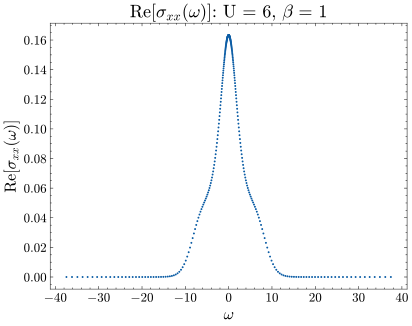

In [108]:
##### Test for one value beta
# Get path (from cleaned up params_df)
parent_dir = '/oak/stanford/orgs/simes/rebjin/nflux1_n0.9/'
beta = 1

path = params_df[params_df['beta']== beta]['path'].item()
print(path)

### Define ws
num_w = 300
ws, dws = maxent.gen_grid(num_w, -2.1, 2.1, lambda x: 0.4 * np.sinh(2.5 * x))
w_lim = np.max(ws)

### Get Re[sigma_xx]
re_sigmas_xx, _ = get_sigma_xx(path, None, ws, dws)
plot_sigmas(ws, re_sigmas_xx, U, beta, yerr = None, ylabel=r'Re[$\sigma_{xx}(\omega)$]')

In [47]:
##### Test for one value beta
# Get path (from cleaned up params_df)
parent_dir = '/oak/stanford/orgs/simes/rebjin/nflux1_n0.9/'
beta = 1

path = params_df[params_df['beta']== beta]['path'].item()
print(path)

### Define ws
num_w = 300
ws, dws = maxent.gen_grid(num_w, -2.1, 2.1, lambda x: 0.4 * np.sinh(2.5 * x))
w_lim = np.max(ws)

### Get Re[sigma_xx]
re_sigmas_xx, _ = get_sigma_xx(path, None, ws, dws)
# Get error with bootstrapping
# num_bs = 25 
# with HiddenPrints():
#     bs_re_sigmas_xx, _ = get_sigma_xx(path, None, ws, dws, bs=num_bs)   # first index bin, second index w
# re_sigmas_xx_err = np.std(bs_re_sigmas_xx, axis=0)

# # plot_sigmas(ws, re_sigmas_xx, U, beta, yerr = re_sigmas_xx_err, ylabel=r'Re[$\sigma_{xx}(\omega)$]')
# # plot_sigmas(ws, re_sigmas_xx, U, beta, ylabel=r'Re[$\sigma_{xx}(\omega)$]')

# ### Get Im[sigma_xy]
# # Get sigmas_sum
# sigmas_sum, _ = get_sigma_sum(path, None, ws, dws, plot_chi_xy=True)
# # Get sigmas_sum error with bootstrapping
# with HiddenPrints():
#     bs_sigmas_sum, _ = get_sigma_sum(path, None, ws, dws, bs=num_bs)   # first index bin, second index w
# sigmas_sum_err = np.std(bs_sigmas_sum, axis=0)

# # Get im_sigmas from subtraction
# im_sigmas_xy = sigmas_sum - re_sigmas_xx    # real
# im_sigmas_xy_err = np.abs(sigmas_sum_err) + np.abs(re_sigmas_xx_err)

# bs_im_sigmas_xy = bs_sigmas_sum - bs_re_sigmas_xx
# bs_im_sigmas_xy_asym =  0.5*(bs_im_sigmas_xy - bs_im_sigmas_xy[:, ::-1]) # antisymmetrize again

/oak/stanford/orgs/simes/rebjin/nflux1_n0.9/beta1_U6_mu-1.135/
L = 10 N (# w) = 300
(6, 6)
(6,)
(6, 300)


TypeError: unsupported operand type(s) for /: 'NoneType' and 'float'

NameError: name 'im_sigmas_err' is not defined

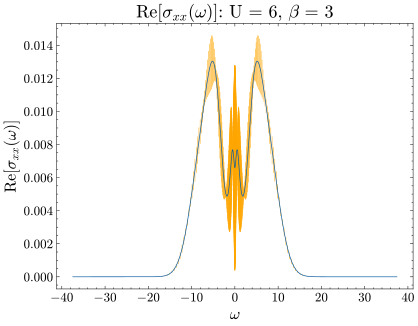

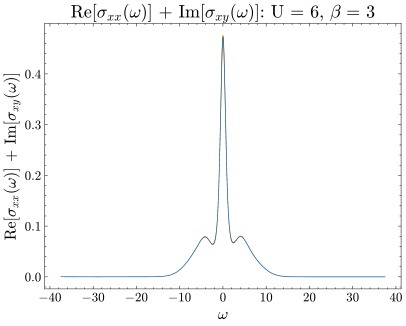

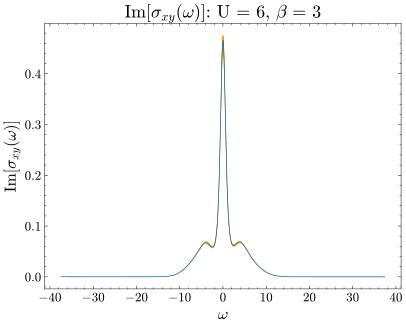

In [11]:
### Plot sigmas so far
plot_sigmas(ws, re_sigmas_xx, U, beta, yerr = re_sigmas_xx_err, ylabel=r'Re[$\sigma_{xx}(\omega)$]')
plot_sigmas(ws, sigmas_sum, U, beta, yerr=sigmas_sum_err, ylabel=r'Re[$\sigma_{xx}(\omega)$] + Im[$\sigma_{xy}(\omega)$]')
plot_sigmas(ws, im_sigmas_xy, U, beta, yerr = im_sigmas_xy_err, ylabel=r'Im[$\sigma_{xy}(\omega)$]')

im_sigmas_xy_asym = 0.5*(im_sigmas_xy - im_sigmas_xy[::-1])   # antisymmetrizing, suspect
im_sigmas_err_asym = 0.5*(im_sigmas_err + im_sigmas_err[::-1])   # antisymmetrizing error (I think this is correct? stupid)
plot_sigmas(ws, im_sigmas_xy_asym, U, beta, yerr = im_sigmas_err_asym, ylabel=r'Im[$\sigma_{xy}(\omega)$]')
plot_sigmas(ws, im_sigmas_xy_asym, U, beta, ylabel=r'Im[$\sigma_{xy}(\omega)$]')

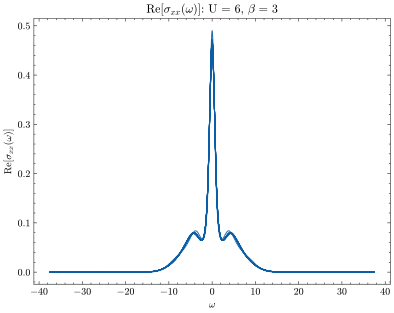

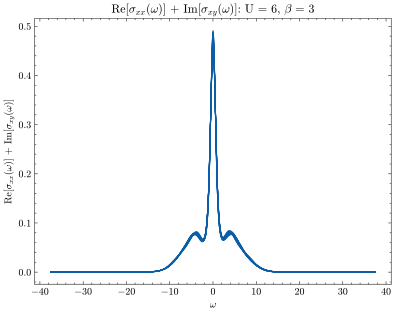

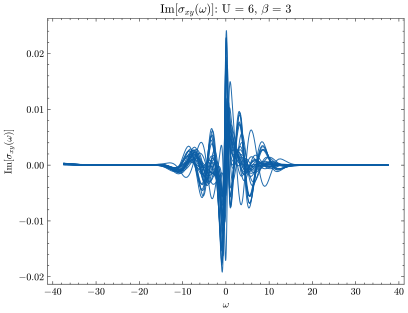

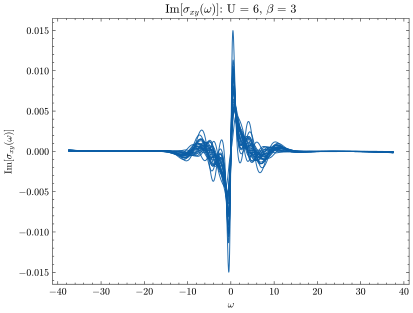

In [50]:
# Alternative view with just all the bootstrapped sigmas plotted on top of each other (check error reasonable)
bs_im_sigmas_xy = bs_sigmas_sum - bs_re_sigmas_xx
bs_im_sigmas_xy_asym =  0.5*(bs_im_sigmas_xy - bs_im_sigmas_xy[:, ::-1]) # antisymmetrize again

plot_sigmas2(ws, bs_re_sigmas_xx, U, beta, ylabel=r'Re[$\sigma_{xx}(\omega)$]')
plot_sigmas2(ws, bs_sigmas_sum, U, beta, ylabel=r'Re[$\sigma_{xx}(\omega)$] + Im[$\sigma_{xy}(\omega)$]')
plot_sigmas2(ws, bs_im_sigmas_xy, U, beta, ylabel=r'Im[$\sigma_{xy}(\omega)$]')

plot_sigmas2(ws, bs_im_sigmas_xy_asym, U, beta, ylabel=r'Im[$\sigma_{xy}(\omega)$]')


DC value: 0.01078570426315173


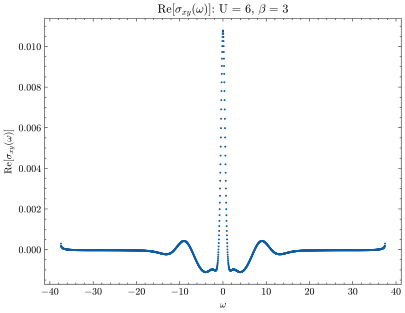

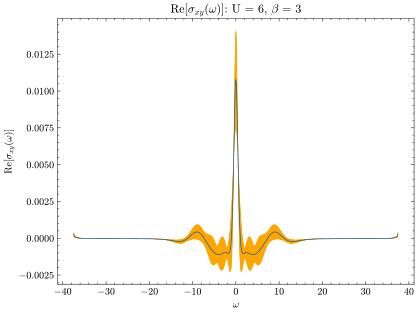

In [53]:
# Get Re[sigma_xy] from Kramers Kronig transform 
# this 1st method doesn't work
# re_sigmas_xy = []
# int_bound = 100
# for w in ws:
#     integral, _ = scipy.integrate.quad(CubicSpline(ws, im_sigmas_xy), -int_bound, int_bound, weight='cauchy', wvar=w)
#     re_sigma_xy = 1/np.pi*integral
#     re_sigmas_xy.append(re_sigma_xy)

### alternate method: use scipy.signal.hilbert()
xs = np.linspace(-w_lim, w_lim, 2500)
fs = CubicSpline(ws, im_sigmas_xy_asym)(xs)
re_sigmas_xy = -np.imag(scipy.signal.hilbert(fs))
# Get error
bs_im_sigmas_xy = bs_sigmas_sum - bs_re_sigmas_xx
bs_im_sigmas_xy_asym =  0.5*(bs_im_sigmas_xy - bs_im_sigmas_xy[:, ::-1]) # antisymmetrize again
bs_re_sigmas_xy = []
for i in range(num_bs):
    fs = CubicSpline(ws, bs_im_sigmas_xy_asym[i])(xs)
    bs_re_sigmas_xy.append(-np.imag(scipy.signal.hilbert(fs)))
re_sigmas_xy_err = np.std(bs_re_sigmas_xy, axis=0)

### Get w-->0: Re[sigma_xy] (DC value)
# re_sigma_xy_dc, _ = scipy.integrate.quad(lambda wp: CubicSpline(ws, im_sigmas_xy)(wp)/np.pi, -int_bound, int_bound, weight='cauchy', wvar=0)
re_sigma_xy_dc = CubicSpline(xs, re_sigmas_xy)(0)
print("DC value:", re_sigma_xy_dc)
# print("DC value2:", re_sigma_xy_dc2)

plot_sigmas(xs, re_sigmas_xy, U, beta, ylabel=r'Re[$\sigma_{xy}(\omega)$]')
plot_sigmas(xs, re_sigmas_xy, U, beta, yerr=re_sigmas_xy_err, ylabel=r'Re[$\sigma_{xy}(\omega)$]')
# plt.savefig('test.png', dpi=250)

In [54]:
### Make a plot for sigma_xy looping through all the temperatures
### does not include error yet

# Choose dir and U to plot from + sigma params
parent_dir = '/oak/stanford/orgs/simes/rebjin/nflux1_n0.9/'
U = 6

num_w = 300
ws, dws = maxent.gen_grid(num_w, -2.1, 2.1, lambda x: 0.4 * np.sinh(2.5 * x))
w_lim = np.max(ws)
xs = np.linspace(-w_lim, w_lim, 2500)
num_bs = 25

# For choice of U, get sigmas(w) for all betas
row_list = []
for path in params_df['path']:
    print(path)
    Ny, Nx, beta, L, tp = util.load_firstfile(
        path, "metadata/Nx", "metadata/Ny", "metadata/beta", "params/L", "metadata/t'"
    )
    T = np.round(1/beta, 2)
    print(f"Params:\nNy = {Ny}, Nx = {Nx}, beta = {np.round(beta, 5)}, L = {L}, tp = {tp}")
    # print(f"Beta = {beta}")

    # Get sigmas_xx
    re_sigmas_xx, _ = get_sigma_xx(path, None, ws, dws)
    # Get errors with bootstrapping
    with HiddenPrints():
        bs_re_sigmas_xx, _ = get_sigma_xx(path, None, ws, dws, bs=num_bs)   # first index bin, second index w
    re_sigmas_xx_err = np.std(bs_re_sigmas_xx, axis=0)

    # Get Im[sigmas_xy]
    sigmas_sum, _ = get_sigma_sum(path, None, ws, dws)
    # Get errors
    with HiddenPrints():
        bs_sigmas_sum, _ = get_sigma_sum(path, None, ws, dws, bs=num_bs)   # first index bin, second index w
    sigmas_sum_err = np.std(bs_sigmas_sum, axis=0)
    im_sigmas_xy = sigmas_sum - re_sigmas_xx    # real
    im_sigmas_xy = 0.5*(im_sigmas_xy - im_sigmas_xy[::-1])    # questionable antisymmetrizing step
    
    # Get Re[sigmas_xy] from Kramers Kronig (Hilbert) transform
    fs = CubicSpline(ws, im_sigmas_xy)(xs)
    re_sigmas_xy = -np.imag(scipy.signal.hilbert(fs))
    # Get errors
    bs_im_sigmas_xy = bs_sigmas_sum - bs_re_sigmas_xx
    bs_im_sigmas_xy_asym =  0.5*(bs_im_sigmas_xy - bs_im_sigmas_xy[:, ::-1]) # questionably antisymmetrize again
    bs_re_sigmas_xy = []
    for i in range(num_bs):
        fs = CubicSpline(ws, bs_im_sigmas_xy_asym[i])(xs)
        bs_re_sigmas_xy.append(-np.imag(scipy.signal.hilbert(fs)))
    re_sigmas_xy_err = np.std(bs_re_sigmas_xy, axis=0)
    
    # Add dict to row_list
    dict = {
        'beta': np.round(beta, 5),
        'U': U, 
        'T': T,
        're_sigmas_xx': re_sigmas_xx,
        're_sigmas_xx_err': re_sigmas_xx_err,
        're_sigmas_xy': re_sigmas_xy,
        're_sigmas_xy_err': re_sigmas_xy_err,
        'im_sigmas_xy': im_sigmas_xy,
        'im_sigmas_xy_err': im_sigmas_xy_err,
        'sigmas_sum': sigmas_sum,
        'sigmas_sum_err': sigmas_sum_err
    }
    row_list.append(dict)
    print('-'*60)
    
# Make DataFrame from list of dicts
df = pd.DataFrame(row_list)
df = df.sort_values(by=['beta'], ascending = False)
df = df.reset_index(drop=True)
print(df)

/oak/stanford/orgs/simes/rebjin/nflux1_n0.9/beta3_U6_mu-1.275/
Params:
Ny = 8, Nx = 8, beta = 3.0, L = 30, tp = 0
alpha=2238.721	chi2/dof=0.628	A.sum()=0.999478
alpha=2238.721	chi2/dof=0.852	A.sum()=0.999754
------------------------------------------------------------
/oak/stanford/orgs/simes/rebjin/nflux1_n0.9/beta2_U6_mu-1.239/
Params:
Ny = 8, Nx = 8, beta = 2.0, L = 20, tp = 0
alpha=1412.538	chi2/dof=1.186	A.sum()=0.999517
alpha=1778.279	chi2/dof=0.857	A.sum()=0.999541
------------------------------------------------------------
/oak/stanford/orgs/simes/rebjin/nflux1_n0.9/beta1.5_U6_mu-1.204/
Params:
Ny = 8, Nx = 8, beta = 1.5, L = 15, tp = 0
alpha=6309.573	chi2/dof=1.766	A.sum()=0.999520
alpha=8912.509	chi2/dof=1.305	A.sum()=0.999632
------------------------------------------------------------
/oak/stanford/orgs/simes/rebjin/nflux1_n0.9/beta1.25_U6_mu-1.167/
Params:
Ny = 8, Nx = 8, beta = 1.25, L = 20, tp = 0
alpha=3981.072	chi2/dof=1.149	A.sum()=0.999938
alpha=4466.836	chi2/dof=0.

In [155]:
def plot_sigmas_T(plot_betas, sigma_name, ylabel, show_err=False, xlim=[], ylim=[]):
        ### df has the data ig
        colors = sns.color_palette('coolwarm', df.shape[0])
        
        fig, ax = plt.subplots(figsize = [6.4, 4.8])
        for beta in plot_betas:
            T = df.loc[df['beta'] == beta, 'T'].item()
            sigmas = df.loc[df['beta'] == beta, sigma_name].item()
            ind = df.loc[df['beta'] == beta].index.tolist()[0]
            # plt.errorbar(ws, sigmas, label = f'T = {T}', color = colors[ind], elinewidth=0.5)
            # plt.scatter(ws, sigmas, label = f'T = {T}', color = colors[ind], s=1)
            if sigma_name == 're_sigmas_xy':
                plot_xs = xs
            else:
                plot_xs = ws
            
            if show_err:
                error_name = sigma_name + '_err'
                errs = df.loc[df['beta'] == beta, error_name].item()
                
                markers, caps, bars = ax.errorbar(plot_xs, sigmas, yerr=errs, fmt='s-', lw=1, ms=0, capsize=0, elinewidth=0.5, color=colors[ind], label = f'T = {T}')
                for bar in bars: bar.set_alpha(0.75)
            else:
                plt.plot(plot_xs, sigmas, label = f'T = {T}', color = colors[ind], lw=1)
        
        plt.legend()
        plt.xlabel(r'$\omega$')
        plt.ylabel(ylabel)
        if xlim: plt.xlim(*xlim)
        if ylim: plt.ylim(*ylim)
        plt.title(f'U = {U}: {ylabel}')
        plt.tight_layout()

def plot_dc_sigmas(sigma_name, ylabel, show_err=False, rho=True):
        # sigmas_dc = []
        # for index, row in df.iterrows():
        #     sigma_dc = CubicSpline(ws, row[sigma_name])(0)
        #     sigmas_dc.append(sigma_dc)
        # sigmas_dc = np.array(sigmas_dc)    ok don't do this I guess lmao
        idx_0 = find_nearest(xs if sigma_name == 're_sigmas_xy' else ws, 0, get_idx = True)  # idx of either ws or xs closest to ws = 0
        sigmas_dc = np.array([sigmas[idx_0] for sigmas in df[sigma_name]])
    
        plt.figure(figsize = [6.4, 4.8])
        if show_err:
            error_name = sigma_name + '_err'
            sigmas_dc_err = np.array([sigmas_err[idx_0] for sigmas_err in df[error_name]])
            rhos_dc_err = (1/sigmas_dc**2)*sigmas_dc_err
            plt.errorbar(df['T'], 1/sigmas_dc if rho else sigmas_dc, yerr=rhos_dc_err if rho else sigmas_dc_err, capsize=1.5)
        else:
            plt.scatter(df['T'], 1/sigmas_dc if rho else sigmas_dc)
            plt.plot(df['T'], 1/sigmas_dc if rho else sigmas_dc)
    
        plt.xlabel('T')
        plt.ylabel(ylabel)
        plt.title(f'U = {U}: {ylabel}')

def plot_dc_sigmas(sigma_name, ylabel, show_err=False, rho=True):
        # sigmas_dc = []
        # for index, row in df.iterrows():
        #     sigma_dc = CubicSpline(ws, row[sigma_name])(0)
        #     sigmas_dc.append(sigma_dc)
        # sigmas_dc = np.array(sigmas_dc)    ok don't do this I guess lmao
        idx_0 = find_nearest(xs if sigma_name == 're_sigmas_xy' else ws, 0, get_idx = True)  # idx of either ws or xs closest to ws = 0
        sigmas_dc = np.array([sigmas[idx_0] for sigmas in df[sigma_name]])
    
        plt.figure(figsize = [6.4, 4.8])
        if show_err:
            error_name = sigma_name + '_err'
            sigmas_dc_err = np.array([sigmas_err[idx_0] for sigmas_err in df[error_name]])
            rhos_dc_err = (1/sigmas_dc**2)*sigmas_dc_err
            plt.errorbar(df['T'], 1/sigmas_dc if rho else sigmas_dc, yerr=rhos_dc_err if rho else sigmas_dc_err, capsize=1.5)
        else:
            plt.scatter(df['T'], 1/sigmas_dc if rho else sigmas_dc)
            plt.plot(df['T'], 1/sigmas_dc if rho else sigmas_dc)
    
        plt.xlabel('T')
        plt.ylabel(ylabel)
        plt.title(f'U = {U}: {ylabel}')

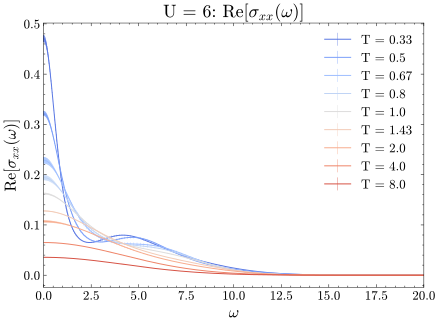

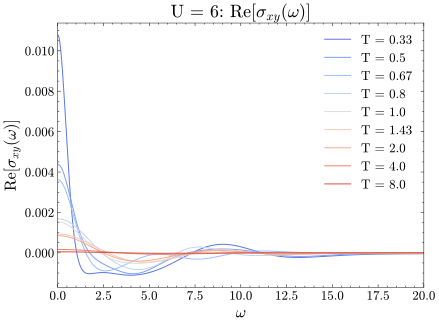

In [159]:
plot_betas = [3, 2, 1.5, 1.25, 1, 0.7, 0.5, 0.25, 0.125]
# plot_sigmas_T(plot_betas, "re_sigmas_xx", ylabel=r'Re[$\sigma_{xx}(\omega)$]', xlim=[0, 20], show_err=True)
# plt.savefig('test.png', dpi=250)
plot_sigmas_T(plot_betas, "re_sigmas_xy", ylabel=r'Re[$\sigma_{xy}(\omega)$]', xlim=[0, 20], show_err=False)
# plt.rcParams.update({'figure.autolayout': True})
plt.savefig('test.png', dpi=250)

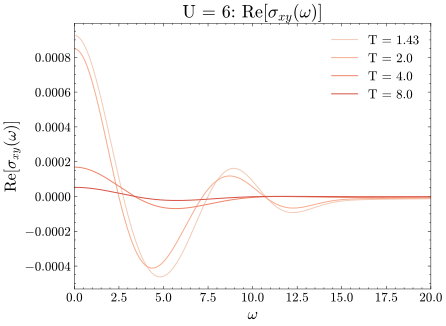

In [135]:
plot_betas = [3, 2, 1.5, 1.25, 1]
plot_betas = [0.7, 0.5, 0.25, 0.125]
plot_sigmas_T(plot_betas, "re_sigmas_xy", ylabel=r'Re[$\sigma_{xy}(\omega)$]', xlim=[0, 20], show_err=False)
plt.savefig('test.png', dpi=250)

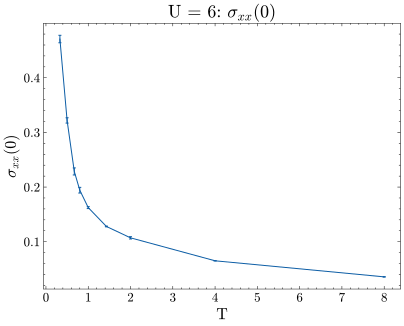

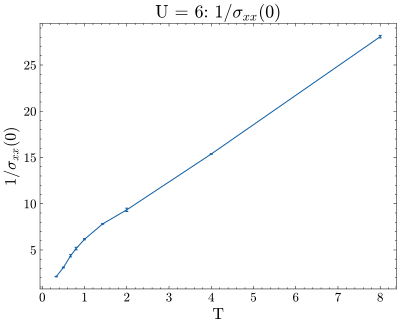

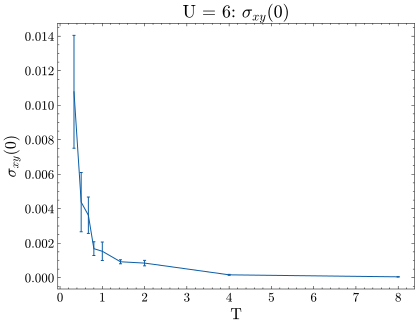

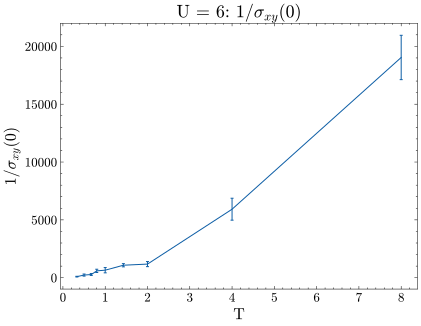

In [137]:
plot_dc_sigmas("re_sigmas_xx", r'$\sigma_{xx}(0)$', rho=False, show_err=True)
plot_dc_sigmas("re_sigmas_xx", r'$1/\sigma_{xx}(0)$', rho=True, show_err=True)
# plt.savefig('test.png', dpi=250)

plot_dc_sigmas("re_sigmas_xy", r'$\sigma_{xy}(0)$', rho=False, show_err=True)
plot_dc_sigmas("re_sigmas_xy", r'$1/\sigma_{xy}(0)$', rho=True, show_err=True)
# plt.savefig('test.png', dpi=250)

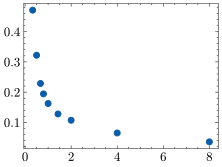

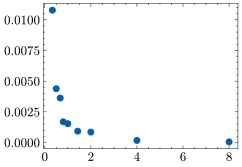

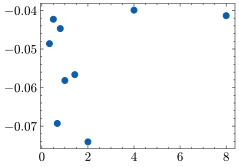

In [152]:
# calculate Hall coefficient (very questionable)
sigma_xx_dc = np.array([CubicSpline(ws, sigmas)(0) for sigmas in df['re_sigmas_xx']])   # vs. T
sigma_xy_dc = np.array([CubicSpline(xs, sigmas)(0) for sigmas in df['re_sigmas_xy']])   # vs. T

plt.figure()
plt.scatter(df['T'], sigma_xx_dc)
plt.figure()
plt.scatter(df['T'], sigma_xy_dc)
a=1
# h=
# B = 1/
R_Hs = -sigma_xy_dc/(sigma_xx_dc**2+sigma_xy_dc**2)
plt.figure()
plt.scatter(df['T'], R_Hs)
# plt.ylim(-80, 1)

In [15]:
# rq relook at what the h5 files look like again, what measurements there are
with h5py.File(path, "r") as f:
    print(list(f.keys()))
    print("Equal time measurements: ", list(f['meas_eqlt'].keys()))
    print("Unequal time measurements: ", list(f['meas_uneqlt'].keys()))

['meas_eqlt', 'meas_uneqlt', 'metadata', 'params', 'state']
Equal time measurements:  ['density', 'double_occ', 'g00', 'n_sample', 'nn', 'pair_sw', 'sign', 'xx', 'zz']
Unequal time measurements:  ['gt0', 'jj', 'jsjs', 'kk', 'ksks', 'n_sample', 'nn', 'pair_bb', 'pair_sw', 'sign', 'xx', 'zz']
